# ADASYN algorithm
### ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning

The ADASYN algorithm is a synthetic sampling approach designed to handle imbalanced learning problems. It generates synthetic data examples based on the density distribution of minority class examples, focusing on those that are more diffficult to learn.

This algorithm contains :

  1.Generate a synthetic dataset using make_classification with a class imbalance.
  2. Normalize the dataset.
  3. Generates synthetic data examples based on the density distribution.
  Combine the original and synthetic samples.
  4. Train a KNN classifier.
  5. Evaluate and visualize the results.

### Step 1: Import Libraries and Create Dataset

In [9]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Create a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.1, 0.9], flip_y=0, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Step 2: Define ADASYN function & Density distribution

In [10]:
# Define the ADASYN function
def adasyn(X, y, beta=0.5, k=5):
    # Initialize the synthetic samples list
    synthetic_samples = []

    # Find the minority class (assuming binary classification with 0 as minority class)
    minority_class = 0

    # Filter minority samples
    minority_samples = X[y == minority_class]
    n_minority_samples = len(minority_samples)

    # Ensure k does not exceed the number of minority samples
    k = min(k, n_minority_samples - 1)

    # Initialize the nearest neighbors model
    knn = NearestNeighbors(n_neighbors=k + 1)  # Including the point itself
    knn.fit(minority_samples)

    # Density distribution
    density_distribution = np.zeros((n_minority_samples,))

    for i in range(n_minority_samples):
        # Find K nearest neighbors
        neighbors = knn.kneighbors([minority_samples[i]], return_distance=False)[0]
        neighbors = neighbors[neighbors != i]  # Exclude the point itself

        # Generate synthetic data examples
        synthetic_samples_i = []
        for j in neighbors:
            # Calculate the difference vector
            diff_vector = minority_samples[j] - minority_samples[i]

            # Generate a synthetic data example
            synthetic_sample = minority_samples[i] + diff_vector * np.random.uniform(0, 1)
            synthetic_samples_i.append(synthetic_sample)

        synthetic_samples.append(synthetic_samples_i)

        # Update the density distribution
        density_distribution[i] = np.mean([np.linalg.norm(syn_sample - minority_samples[i]) for syn_sample in synthetic_samples_i])

    # Balance the data
    balanced_samples = []
    for i in range(n_minority_samples):
        if density_distribution[i] > beta:
            balanced_samples.append(minority_samples[i])
        else:
            synthetic_samples_i = synthetic_samples[i]
            balanced_samples.append(synthetic_samples_i[np.argmax([np.linalg.norm(syn_sample - minority_samples[i]) for syn_sample in synthetic_samples_i])])

    # Convert the list to a numpy array
    synthetic_samples = np.array(balanced_samples)

    return synthetic_samples

# Generate synthetic samples using ADASYN
synthetic_samples = adasyn(X_scaled, y)

# Append the synthetic samples to the original data
X_augmented = np.concatenate((X_scaled, synthetic_samples), axis=0)
y_augmented = np.concatenate((y, np.zeros(len(synthetic_samples))), axis=0)

### Step 3: Train and Evaluate the Model

In [11]:
# Define a classifier model (using KNN for simplicity)
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_augmented, y_augmented)

# Evaluate the model
y_pred = classifier.predict(X_augmented)
print("Accuracy:", accuracy_score(y_augmented, y_pred))
print("Classification Report:")
print(classification_report(y_augmented, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_augmented, y_pred))

Accuracy: 0.9754545454545455
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       200
         1.0       0.98      0.99      0.99       900

    accuracy                           0.98      1100
   macro avg       0.96      0.96      0.96      1100
weighted avg       0.98      0.98      0.98      1100

Confusion Matrix:
[[185  15]
 [ 12 888]]


### Step 4: Visualize the Results

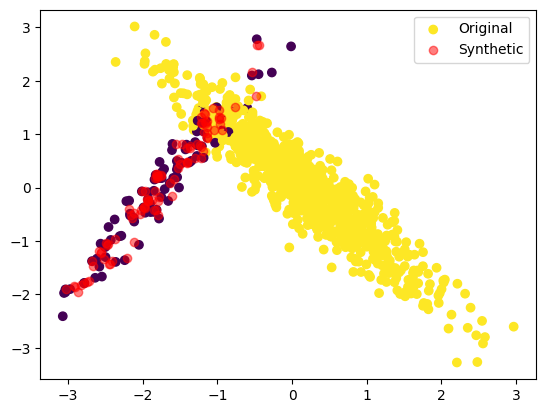

In [12]:
# Visualize the results
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, label='Original')
plt.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1], c='r', label='Synthetic', alpha=0.5)
plt.legend()
plt.show()